In [1]:
import tensorsketch as ts
import tqdm
import numpy as np
from Bio import SeqIO
import glob
import matplotlib.pyplot as plt

import edlib

In [2]:
kmer_size = 8               #@param {type:"slider",min:1,max:32,step:1}
tuple_size = 3              #@param {type:"slider",min:1,max:10,step:1}
sketch_dim = 10             #@param {type:"slider",min:10,max:300,step:10}
run_cuda_models = False     #@param {type:"boolean"}
alphabet_size = 4
seq_len = 5000000

window = 100000
stride = 20000
normalize = True
sample = ord('m')

common = dict(A=alphabet_size,D=sketch_dim)
tss = ts.TSS(t=tuple_size, S=stride, W=window, **common)

tsm = ts.TSM(t=tuple_size, S=stride, W=window, normalize=normalize,sample=sample,**common)

In [3]:

# Map from sequence characters to internal integer representation.
_char_map: dict[str, int] = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
_char_comp: dict[str, str] = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}

def reverse_complement(s) -> np.ndarray:
    char_list = np.full(len(s), -1, dtype=np.int8)
    for i in range(len(s)):
        char_list[i] = _char_map[_char_comp[s[-i-1]]]
    return char_list

# Given the char_map above, returns an array of length 256 mapping bytes to
# internal integers. -1 signals unknown bytes.
def seq2array(s) -> np.ndarray:
    char_list = np.full(len(s), -1, dtype=np.int8)
    for i,k in enumerate(s):
        char_list[i] = _char_map[k]
    return char_list

data = "/Users/amirjoudaki/Downloads/S_Baltica_new"
files = glob.glob(data + '/*')
print(files)

all_seqs = []
for file in files:
    records = SeqIO.to_dict(SeqIO.parse(file, "fasta"))
    for name,record in records.items():
        seq = dict(file = file, id=record.id, name=record.name, description=record.description)
        seq['seq'] = record.seq
        seq['array'] = seq2array(record.seq)
        seq['rarray'] = seq2array(record.seq)
        all_seqs.append(seq)

all_seqs

['/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS223.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS675.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS117.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS195.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS185.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS625.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_BA175.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS155.new.new.all.fna']


[{'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS223.new.new.all.fna',
  'id': 'CP001252.1',
  'name': 'CP001252.1',
  'description': 'CP001252.1 Shewanella baltica OS223 chromosome, complete genome 0',
  'seq': Seq('TTTTTTAAGGATAGCGATCCTTGAGATCTCGCTATAGAATACACCTCTTTTTTG...GCG'),
  'array': array([3, 3, 3, ..., 2, 1, 2], dtype=int8),
  'rarray': array([3, 3, 3, ..., 2, 1, 2], dtype=int8)},
 {'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS675.new.new.all.fna',
  'id': 'CP002383.1',
  'name': 'CP002383.1',
  'description': 'CP002383.1 Shewanella baltica OS678, complete genome 0',
  'seq': Seq('TTTAAGGATAGCGATCCTTGAGATCTCGCTATAGAATACACCTCTTTTTTGATG...TAA'),
  'array': array([3, 3, 3, ..., 3, 0, 0], dtype=int8),
  'rarray': array([3, 3, 3, ..., 3, 0, 0], dtype=int8)},
 {'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS117.new.new.all.fna',
  'id': 'C_017579.1',
  'name': 'C_017579.1',
  'description': 'C_017579.1 Shewanella baltica OS117, co

In [5]:
%%time
for seq in tqdm.tqdm(all_seqs,total=len(all_seqs)):
    # seq['sketch'] = dict(name='tss',
    #                      array=tss.sketch(seq['array'],flatten=False),
    #                      rarray=tss.sketch(seq['rarray'],flatten=False))
    sketch, inds = tsm.sketch(seq['array'])
    rsketch, rinds = tsm.sketch(seq['rarray'])
    seq['sketch'] = dict(name='tsm',
                         array=sketch,
                         inds=inds,
                         rarray=rsketch,
                         rinds=rinds)

100%|██████████| 8/8 [01:22<00:00, 10.36s/it]

CPU times: user 1min 5s, sys: 7.57 s, total: 1min 12s
Wall time: 1min 22s


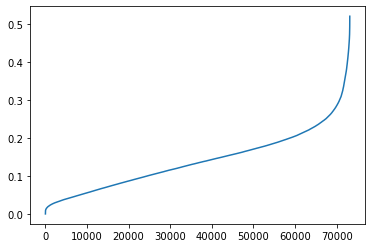

In [29]:
import edlib
import pandas as pd
si, sj = 0, 2
sk1, sk2 = all_seqs[si]['sketch']['array'], all_seqs[sj]['sketch']['array']
dists = []
for i,s1 in enumerate(sk1):
    for j,s2 in enumerate(sk2):
        n1, n2 = np.linalg.norm(s1), np.linalg.norm(s2)
        if n1==0 or n2==0:
            continue
        d = np.linalg.norm(s1/n1-s2/n2)
        dists.append((i,j,d))
dists = np.array(dists)
idx = np.argsort(dists[:,2])
dists = dists[idx,:]
plt.plot(dists[:,2])

In [ ]:
num_samples = 27
uniform_dists = np.random.random(num_samples)*(dists[-1,2]-dists[0,2])+dists[0,2]
uniform_indices = np.searchsorted(dists[:,2],uniform_dists)
uniform_indices = list(range(20))
df = pd.DataFrame(columns=['s1','s2','i1','i2','j1','j2','d','ed','ed_norm'])
for index in tqdm.tqdm(uniform_indices):
    i, j, d = int(dists[index,0]),int(dists[index,1]), dists[index,2]
    idx1,idx2 = all_seqs[si]['sketch']['inds'][i], all_seqs[sj]['sketch']['inds'][j]
    if idx1<window or idx2<window:
        continue
    seq1, seq2 = all_seqs[si]['seq'][idx1-window:idx1],all_seqs[sj]['seq'][idx2-window:idx2]
    query, target = seq1,seq2
    result = edlib.align(query,target,task='path')
    nice = edlib.getNiceAlignment(result, query, target)
    first = nice['matched_aligned'].find('|'*30)
    query_aligned = nice['query_aligned'][:first]
    target_aligned = nice['target_aligned'][:first]
    d1, d2 = query_aligned.count('-'), target_aligned.count('-')
    L = window - max(d1,d2)
    result2 = edlib.align(target[d1:d1+L],query[d2:d2+L])

    # print("\n".join([str(v) for k,v in nice.items()]))
    df.loc[len(df),:] = (si,sj,idx1-window,idx1,idx2-window,idx2,d,result2['editDistance'],result2['editDistance']/L)
df

 90%|█████████ | 18/20 [01:00<00:08,  4.09s/it]

In [165]:
df

,s1,s2,i1,i2,j1,j2,d,ed,ed_norm
0,0,2,-99865,135,-99864,136,0.001377,12736,0.134035
1,0,2,-99968,32,-99961,39,0.005932,44826,0.514798
2,0,2,-99783,217,-99836,164,0.005975,44937,0.515681
3,0,2,-99927,73,-99963,37,0.006726,44880,0.515027
4,0,2,-99892,108,-99928,72,0.006984,44972,0.515551
5,0,2,-99892,108,-99927,73,0.007097,44995,0.516371
6,0,2,-99927,73,-99884,116,0.007422,44891,0.515195
7,0,2,-99942,58,-99951,49,0.007451,44832,0.515198
8,0,2,-99824,176,-99851,149,0.007972,44945,0.515708


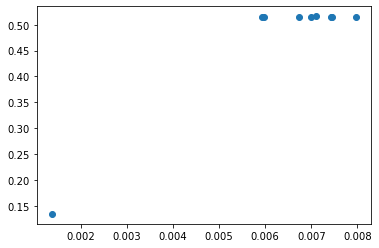

In [166]:
plt.scatter(df.d, df.ed_norm)

27


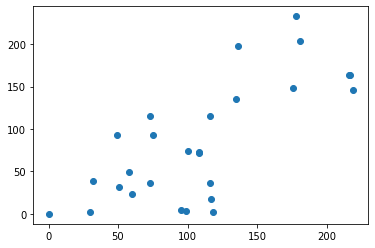

In [80]:
inds = dists[:,2]<0.01
print(sum(inds))
plt.scatter(dists[inds,0],dists[inds,1])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

N = len(all_seqs)

for i in range(N):
    for j in range(i,N):
        sk1 = all_seqs[i]['sketch']['array']
        sk2 = all_seqs[j]['sketch']['array']
        sk1 = sk1.transpose() / np.sqrt(np.sum(sk1**2,axis=1))
        sk2 = sk2.transpose() / np.sqrt(np.sum(sk2**2,axis=1))
        prod = np.matmul(sk1.transpose(),sk2)
        angle = np.arccos(prod) / np.pi

        plt.matshow(angle)
        plt.colorbar()
        plt.title(f'seq {i} vs. seq {j}')
        plt.show()

In [90]:
dists.shape

(267, 267)

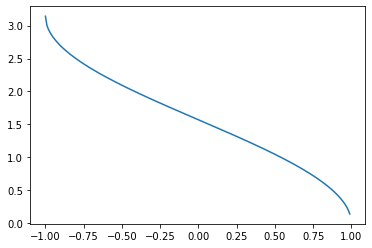

In [86]:
x = np.arange(-1,1,.01)
plt.plot(x,np.arccos(x))

3.141592653589793